In [1]:
import pandas as pd
import spacy
import steamreviews
import json
import csv
import os
import glob
import json
import matplotlib.pyplot as plt
import nltk
import wordcloud
import re
import plotly
import seaborn as sns
import stanza
import string 
import joblib

from scipy.stats import pearsonr
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from wordcloud import WordCloud
from pandas.io.json import json_normalize
from nltk.corpus import stopwords
from tqdm.notebook import trange, tqdm
from sklearn.cluster import KMeans

C:\Users\marty\AppData\Local\Programs\Python\Python311\Lib\site-packages\thinc\compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
C:\Users\marty\AppData\Local\Programs\Python\Python311\Lib\site-packages\thinc\compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]


## Reviews download
https://pypi.org/project/steamreviews/

In [2]:
dir_name = "data"
reviews_jsons = glob.glob(f"{dir_name}/*")
reviews_jsons

['data\\review_1150690.json',
 'data\\review_1172620.json',
 'data\\review_1341290.json',
 'data\\review_1515210.json',
 'data\\review_210970.json',
 'data\\review_219150.json',
 'data\\review_219890.json',
 'data\\review_250320.json',
 'data\\review_257510.json',
 'data\\review_262060.json',
 'data\\review_289070.json',
 'data\\review_294100.json',
 'data\\review_304430.json',
 'data\\review_394360.json',
 'data\\review_400.json',
 'data\\review_427520.json',
 'data\\review_460950.json',
 'data\\review_550.json',
 'data\\review_620.json',
 'data\\review_632470.json',
 'data\\review_646570.json',
 'data\\review_736260.json',
 'data\\review_860510.json']

In [3]:
title_dict = {"219150": "Hotline Miami",
              "1172620" : "Sea of Thieves",
              "460950" : "Katana ZERO",
              "262060" : "Darkest Dungeon",
              "250320" : "The Wolf Among Us",
              "210970" : "The Witness",
              "620" : "Portal 2",
              "736260" : "Baba Is You",
              "219890" : "Antichamber",
              "289070" : "Sid Meier's Civilization VI",
              "427520" : "Factorio",
              "257510" : "The Talos Principle",
             "304430" : "INSIDE",
             "400" : "Portal",
             "394360" : "Hearts of Iron IV",
             "632470" : "Disco Elysium",
             "294100" : "RimWorld",
              "646570" : "Slay the Spire",
              "1150690" : "Omori",
              "1341290" : "We Were Here Forever",
              "1515210" : "The Past Within",
              "860510" : "Little Nightmares II",
              "550" : "Left 4 Dead 2"}

In [4]:
genre_dict = {"219150": "A",
              "1172620" : "A",
              "460950" : "A",
              "262060" : "R",
              "250320" : "R",
              "210970" : "P",
              "620" : "P",
              "736260" : "P",
              "219890" : "P",
              "289070" : "S",
              "427520" : "S",
              "257510" : "P",
              "304430" : "P",
             "400" : "P",
             "394360" : "S",
             "632470" : "R",
             "294100" : "S",
             "646570" : "R",
             "1150690" : "R",
             "1341290" : "P",
             "1515210" : "P",
             "860510" : "P",
             "550" : "A"}

In [5]:
data_list = []
for i in reviews_jsons:
    with open(i, encoding = "utf-8") as json_file:
        json_data = json.load(json_file)
        reviews = json_data['reviews']
        file_name = json_file.name.split('.')[0].split('_')[1]
        for key in reviews.keys():
            data_list.append([title_dict.get(file_name),genre_dict.get(file_name),reviews[key]['author']['steamid'], reviews[key]['votes_up'], 
                          reviews[key]['review'], reviews[key]['weighted_vote_score'], reviews[key]['voted_up'],
                          reviews[key]['author']['num_games_owned'], reviews[key]['author']['playtime_at_review'],
                          reviews[key]['author']['num_reviews'], 
                          reviews[key]["timestamp_created"] ])
df = pd.DataFrame(data_list, columns = ["title", "genre","steamid", "votes_up", "review", "weighted_vote_score", "voted_up",
                                        "num_games_owned", "playtime_at_review", "num_reviews", "timestamp_created"])

In [6]:
df.sample(frac=0.3).head()

,title,genre,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created
14481,RimWorld,S,76561198041312774,72,[i]RimWorld[/i] is all about building up a nic...,0.781811714172363281,True,833,5050,90,1703362624
26025,Portal 2,P,76561197968578135,1,Great puzzles solo or in tandem.,0.527559041976928711,True,0,841,106,1690217102
4094,Sea of Thieves,A,76561199091245362,1,sailor bussy reaks of clams,0.523809552192687988,True,0,652,7,1674785935
4006,Sea of Thieves,A,76561198154007800,1,no sex,0.523809552192687988,True,197,5337,11,1676403897
2711,Sea of Thieves,A,76561198025707177,2,Quite a fun game for a small group of friends....,0.545454561710357666,True,0,13089,10,1665098035


In [7]:
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], unit='s')

## Preprocessing

1. Braki danych
2. Usunięcie duplikatów
4. Usunięcie recenzjii krótszych niż 3 słowa
9. Usunięcie znaków spcjalnych 
10. "Text lowering"
6. Usunięcie znaków interpunkcyjnych i liczb
8. Usunięcie tytułów gier z recenzji
7. Tokenizacja
8. Part-of-speech tagging
9. Lematyzacja

#### Braki danych

In [8]:
df.isna().sum()

title                  0
genre                  0
steamid                0
votes_up               0
review                 0
weighted_vote_score    0
voted_up               0
num_games_owned        0
playtime_at_review     0
num_reviews            0
timestamp_created      0
dtype: int64

#### Usunięcie duplikatów

In [9]:
df.duplicated(subset='review').sum()

2580

In [10]:
df[df.duplicated(subset='review')].sample(20)

,title,genre,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created
18698,Portal,P,76561198980325382,1,GG,0.523809552192687988,True,43,369,9,2022-11-28 13:58:03
13821,RimWorld,S,76561198080451663,2,yeah its alright i guess,0.521255970001220703,True,0,22508,35,2023-06-03 08:16:46
17048,Hearts of Iron IV,S,76561199235545007,1,better than sex,0.512711822986602783,True,26,18409,1,2023-05-06 03:36:06
26071,Portal 2,P,76561199107704702,1,potato,0.525862038135528564,True,84,298,22,2022-12-11 03:16:27
23198,Left 4 Dead 2,A,76561198285831749,2,If you're looking for a review on this game yo...,0.523809552192687988,True,118,1498,17,2023-04-19 23:01:48
23576,Left 4 Dead 2,A,76561199444706651,1,Epic game,0.523809552192687988,True,9,244,10,2023-02-17 22:03:10
5774,Sea of Thieves,A,76561198146234933,1,Gud,0.504504501819610596,True,377,299,28,2023-08-27 21:21:55
21721,Katana ZERO,A,76561198100336127,16,👍,0.627693474292755127,True,300,483,33,2023-11-08 15:32:57
18115,Portal,P,76561199024346124,1,nice,0.523809552192687988,True,25,141,16,2023-09-15 18:27:52
27168,Portal 2,P,76561198174565630,1,.,0.523809552192687988,True,0,278,18,2022-11-26 00:10:21


In [11]:
(df.duplicated(subset='review') == False).sum()

29492

In [12]:
df = df[df.duplicated(subset='review') == False]

In [13]:
df.duplicated(subset='review').sum()

0

#### Długość recenzji

In [14]:
df["temp_review_len"] = df["review"].apply(lambda x: x.split(" ").__len__())
df["temp_review_len"].describe()

count    29492.000000
mean        54.191984
std        135.354534
min          1.000000
25%          5.000000
50%         13.000000
75%         39.000000
max       3997.000000
Name: temp_review_len, dtype: float64

In [15]:
df[df["temp_review_len"] < 4].groupby(by=["genre"]).count()

,title,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created,temp_review_len
genre,,,,,,,,,,,
A,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659
P,852,852,852,852,852,852,852,852,852,852,852
R,798,798,798,798,798,798,798,798,798,798,798
S,1140,1140,1140,1140,1140,1140,1140,1140,1140,1140,1140


In [16]:
df = df[df["temp_review_len"] >= 3]

In [17]:
suma = 0
for i in df["temp_review_len"]:
    suma += i

In [18]:
print("Ilość słów:", suma,
     "Ilość recenzji:", len(df["temp_review_len"]))

Ilość słów: 1593992 Ilość recenzji: 26663


In [19]:
df = df.drop(["temp_review_len"], axis=1)

### Wordcloud

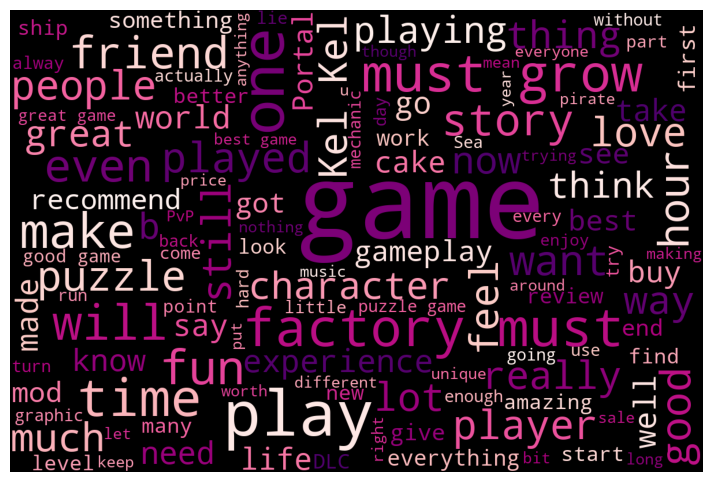

In [20]:
txt = ' '.join(i for i in df["review"])
wordcloud = WordCloud(max_font_size = 180,
                max_words = 120,
                width = 1200,
                height = 800,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

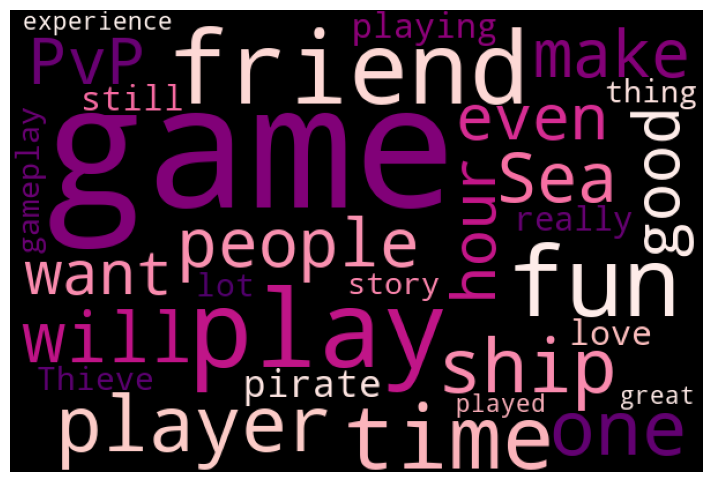

In [21]:
txt = ' '.join(i for i in df[df['genre'] == "A"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

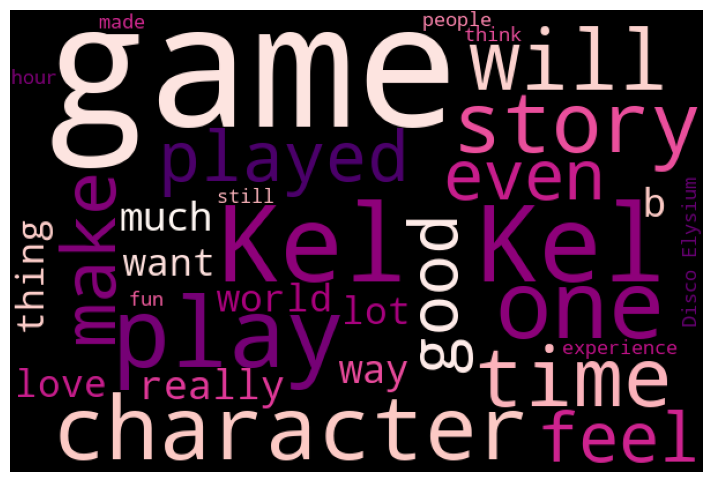

In [22]:
txt = ' '.join(i for i in df[df['genre'] == "R"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

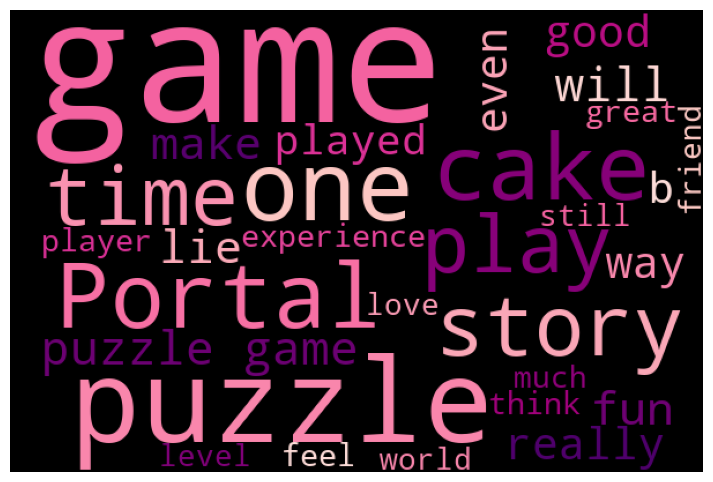

In [23]:
txt = ' '.join(i for i in df[df['genre'] == "P"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

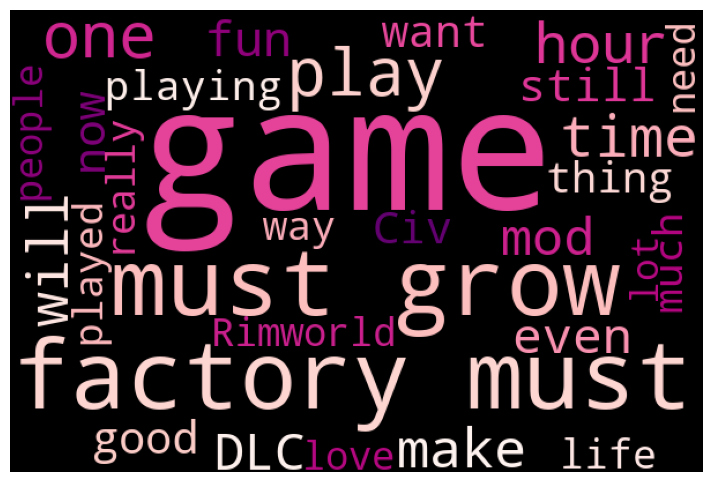

In [24]:
txt = ' '.join(i for i in df[df['genre'] == "S"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

#### Usunięcie znaków, text lowering

In [25]:
df["review"] = df["review"].str.replace(r"\[.*?\]|\n|[^\x00-\x7F]+", "", regex=True).str.lower()

In [26]:
df["review"].sample(10)

1402                                         what the fuck
25061                                baron bunny pipe bomb
5155     gets boring after 1 run , you lose everything ...
6865     great game loved playing it with a friend. hop...
31882    10/10tl;dr: creepy atmosphere and fantastic st...
22236                      it is what it is. :)is good :))
9877     spent $200 on dlc only for it to go on sale fo...
14314                       best war crime simulator ever.
10736    started playing this game fours years ago and ...
25285                            kunno v8 kranaatin heitin
Name: review, dtype: object

#### Usunięcie znaków interpunkcyjnych i liczb

In [27]:
df["review"] = df["review"].str.replace(r"[0-9]", "", regex=True)

In [28]:
df["review"] = df["review"].str.replace('['  + string.punctuation + ']', "", regex =True)

In [29]:
df["review"].sample(5)

26684    the target is lostsearchingtarget lostsearchin...
14629    im soooo gamer now i looked up how to solve so...
16243    i can make thailand a true democracy in mod an...
5045     i was groomed by a fat man wearing a purple pe...
13226                                   i cant stop gaming
Name: review, dtype: object

#### Usunięcie tytułów gier z recenzji

In [30]:
for value in title_dict.values():
    df["review"] = df["review"].str.replace(value.lower(), "")

#### Tokenizacja

In [31]:
df["tokenized"] = df["review"].apply(nltk.word_tokenize)

In [32]:
df["tokenized"].sample(15)

14551    [theres, a, fine, line, between, creating, a, ...
31583    [this, game, is, simple, and, intuitive, yet, ...
22315    [its, pretty, fun, was, never, into, zombie, s...
22201          [gnomeo, gnomeoe, where, art, thou, gnomeo]
10480    [this, is, is, an, accurate, simulation, of, w...
28210    [you, might, know, why, im, giving, this, game...
16731    [holy, fucking, shit, is, that, a, motherfucki...
7120     [of, it, is, perfect, which, is, why, youre, s...
9099     [i, play, this, since, it, was, out, and, i, h...
9032     [is, a, turn, based, combat, game, where, your...
30629                                   [you, have, cards]
23339               [katana, go, brrrrr, on, the, zombies]
2571     [this, game, is, breathtakingly, beautiful, yo...
24601                              [fun, game, with, gore]
17929    [incredible, game, would, highly, recommend, i...
Name: tokenized, dtype: object

### Stopwords

In [33]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
english_stopwords = stopwords.words('english')
english_stopwords_cleaned = [word.replace("'", "") for word in english_stopwords]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
new_column = []
for row in df["tokenized"]:
    new_row = [word for word in row if word[0] not in english_stopwords_cleaned]
    new_column.append(new_row)
df["final_review"] = new_column

## Describe

In [35]:
df.dtypes

title                          object
genre                          object
steamid                        object
votes_up                        int64
review                         object
weighted_vote_score            object
voted_up                         bool
num_games_owned                 int64
playtime_at_review              int64
num_reviews                     int64
timestamp_created      datetime64[ns]
tokenized                      object
final_review                   object
dtype: object

In [36]:
df["weighted_vote_score"] = pd.to_numeric(df["weighted_vote_score"])

In [37]:
df["voted_up"] = pd.to_numeric(df["voted_up"])

In [38]:
df.describe()

,votes_up,weighted_vote_score,num_games_owned,playtime_at_review,num_reviews
count,26663.000000,26663.000000,26663.000000,2.666300e+04,26663.000000
mean,31.715148,0.570098,140.866707,1.309372e+04,21.467689
std,173.097223,0.109932,538.652824,4.720263e+04,59.809381
min,0.000000,0.500000,0.000000,5.000000e+00,1.000000
25%,1.000000,0.521739,0.000000,5.350000e+02,3.000000
50%,1.000000,0.523810,0.000000,1.800000e+03,8.000000
75%,3.000000,0.545180,113.000000,7.111500e+03,20.000000
max,9568.000000,0.987843,22780.000000,1.890626e+06,3419.000000


C:\Users\marty\AppData\Local\Temp\ipykernel_13392\2852639080.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method = "pearson")


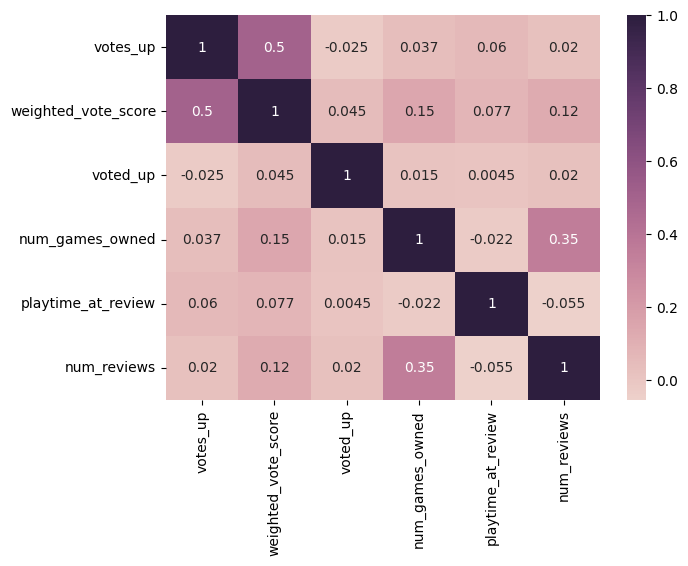

In [39]:
corr = df.corr(method = "pearson")
plt.figure(figsize=(7,5))
sns.heatmap(corr, cmap=sns.cubehelix_palette(as_cmap=True),annot=True)
plt.show()

## Wykresy

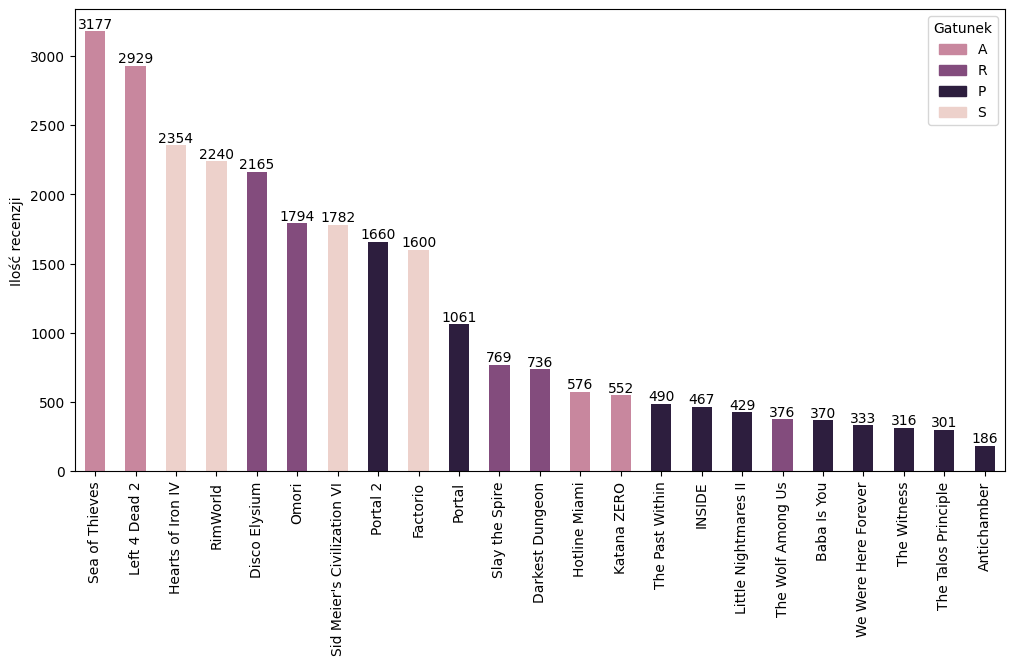

In [40]:
value_counts_title = df["title"].value_counts()
genre_colors = {"A": sns.cubehelix_palette(4)[1], "R": sns.cubehelix_palette(4)[2], "P": sns.cubehelix_palette(4)[3], 
                "S": sns.cubehelix_palette(4)[0]}
df['color'] = df['genre'].map(genre_colors)
colors = [df.loc[df['title'] == title]['color'].iloc[0] for title in value_counts_title.index]

plt.figure(figsize=(12, 6))
x = value_counts_title.plot(kind = "bar", color = colors)
plt.ylabel("Ilość recenzji")
plt.xticks(rotation = 90)
for i, count in enumerate(value_counts_title):
    x.text(i, count, count, va = "bottom", ha = "center")

handles = [plt.Rectangle((0,0), 1,1, color=genre_colors[label]) for label in genre_colors]
plt.legend(handles, genre_colors.keys(), title="Gatunek", loc="upper right")


plt.show()
df = df.drop(["color"], axis=1)

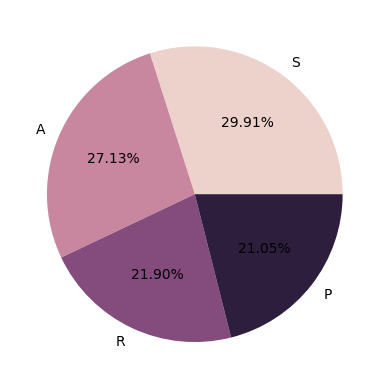

In [41]:
value_counts_genre = df["genre"].value_counts()
colors = sns.cubehelix_palette(4)
x = plt.pie(value_counts_genre, labels = value_counts_genre.index, colors=colors, autopct='%1.2f%%')
plt.show()

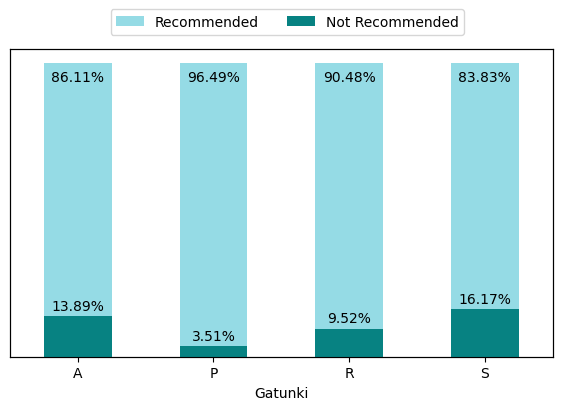

In [42]:
value_counts_recommendation_genre = df.groupby('genre').voted_up.value_counts().unstack(0)
percentage_pos = value_counts_recommendation_genre.iloc[1] / (value_counts_recommendation_genre.iloc[1] + value_counts_recommendation_genre.iloc[0]) * 100 
percentage_neg = value_counts_recommendation_genre.iloc[0] / (value_counts_recommendation_genre.iloc[0] + value_counts_recommendation_genre.iloc[1]) * 100 

total_count = percentage_pos + percentage_neg

def addlabels_neg(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] + 2, f"{x[i]:.2f}%",  ha = "center")

def addlabels_pos(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] - 6, f"{y[i]:.2f}%",  ha = "center")

fig, ax1 = plt.subplots(figsize=(7, 4))
ax2 = ax1.twinx()

total_count.plot(kind="bar", color="#95DBE5FF",  label="Recommended")
percentage_neg.plot(kind="bar", color="#078282FF", label="Not Recommended")

ax1.set_xlabel("Gatunki")
ax1.tick_params(axis="y", left=False, labelleft=False)
ax2.tick_params(axis="y", right=False, labelright=False)

addlabels_neg(percentage_neg, total_count) 
addlabels_pos(total_count, percentage_pos) 

plt.legend(bbox_to_anchor=(0.85, 1.15), ncol=2)
plt.show()

## Dependency parser test

In [43]:
test = [df["final_review"][6543], df["final_review"][4534], df["final_review"][12345], df["final_review"][12354],
        df["final_review"][1925], df["final_review"][1067],df["final_review"][22951],df["final_review"][2231],
       ["not","fun", "gameplay"], df["tokenized"][832], df["final_review"][21], df["tokenized"][27061],
       df["final_review"][11088], df["final_review"][3171], df["final_review"][7834], df["final_review"][20180],
       df["final_review"][6697], df["final_review"][893]]

In [44]:
import stanza
nlp = stanza.Pipeline('en', tokenize_pretokenized=True) 
doc = nlp(test)

2024-05-23 16:06:40 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-05-23 16:06:40 INFO: Downloaded file to C:\Users\marty\stanza_resources\resources.json
2024-05-23 16:06:41 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2024-05-23 16:06:41 INFO: Using device: cuda
2024-05-23 16:06:41 INFO: Loading: tokenize
2024-05-23 16:06:41 INFO: Loading: mwt
2024-05-23 16:06:41 INFO: Loading: pos
2024-05-23 16:06:42 INFO: Loading: lemma
2024-05-23 16:06:42 INFO: Loading: constituency
2024-05-23 16:06:42 INFO: Loading: depparse
2024-05-23 16:06:43 INFO: Loading: sentiment
2024-05-23 16:06:43 INFO: Loading: ne

In [45]:
dependency_list = []
for dependency in doc.sentences[13].dependencies:
    dependency_list.append([dependency[2].text, dependency[0].id, dependency[1]])
    
for i in range(0, len(dependency_list)):
    if (int(dependency_list[i][1]) != 0):
        dependency_list[i][1] = test[13][(int(dependency_list[i][1]) - 1)]

print(*dependency_list[:20], sep='\n')

['crewing', 0, 'root']
['game', 'value', 'compound']
['value', 'crewing', 'obj']
['likely', 'crewing', 'advmod']
['worthless', 'crewing', 'xcomp']
['real', 'crewing', 'xcomp']
['but', 'play', 'cc']
['can', 'play', 'aux']
['play', 'crewing', 'conj']
['player', 'play', 'obj']
['but', 'want', 'cc']
['cant', 'want', 'aux']
['really', 'want', 'advmod']
['want', 'crewing', 'conj']
['like', 'graphics', 'discourse']
['game', 'fun', 'compound']
['fun', 'graphics', 'amod']
['graphics', 'want', 'obj']
['basic', 'want', 'xcomp']
['but', 'have', 'cc']


In [46]:
feature_list = []
feature_opinion_list = [] 

for dependency in doc.sentences[13].dependencies:
    if dependency[2].xpos == "RB":
        opinion_word = dependency[2]
        rb_adj = dependency[0]
        
    if (dependency[2].xpos in ["NN", "NNS", "JJ", "JJS", "JJR"]) and (dependency[1] in ["amod"]):
        if dependency[0] == rb_adj or dependency[2] == rb_adj:
            if dependency[2].xpos in ["JJS", "JJR"]:
                result_dict = {'feature': dependency[0].lemma, 'opinion': opinion_word.text + " " + dependency[2].text}
            else:
                result_dict = {'feature': dependency[0].lemma, 'opinion': opinion_word.text + " " + dependency[2].lemma}     
        else:
            if dependency[2].xpos in ["JJS", "JJR"]:
                result_dict = {'feature': dependency[0].lemma, 'opinion': dependency[2].text}
            else:
                result_dict = {'feature': dependency[0].lemma, 'opinion': dependency[2].lemma}  

        feature_list.append(dependency[0].lemma)
        feature_opinion_list.append(result_dict)

print(f'Feature list: {feature_list}')
print(f'Feature-opinion list: {feature_opinion_list}')

Feature list: ['graphic', 'beauty', 'player', 'player', 'player', 'guide', 'reward', 'reward', 'reward']
Feature-opinion list: [{'feature': 'graphic', 'opinion': 'fun'}, {'feature': 'beauty', 'opinion': 'real'}, {'feature': 'player', 'opinion': 'unbalanced'}, {'feature': 'player', 'opinion': 'janky'}, {'feature': 'player', 'opinion': 'human'}, {'feature': 'guide', 'opinion': 'necessary'}, {'feature': 'reward', 'opinion': 'risky'}, {'feature': 'reward', 'opinion': 'lowest'}, {'feature': 'reward', 'opinion': 'highest'}]


## Dependency parser final

In [47]:
with open('opinions.json', 'r') as file:
    dct = json.load(file)

In [48]:
feature_list = []

for i in range(len(df)):
    index = str(i)  
    feature = dct.get(index)
    if feature is None:
        feature_list.append([])
    else:
        feature_list.append(feature)

df["feature"] = feature_list

In [49]:
df = df[df["feature"].apply(lambda x: len(x) > 0)]

In [50]:
words = []
for i in df["feature"]:
    for j in i:
        words.append(j["feature"])

In [51]:
unique_words = list(set(words))

In [52]:
word_counts = pd.DataFrame([[i, len([q for q in words if q==i])] for i in unique_words], 
              columns=['word', 'count']).sort_values('count', ascending=False)

## Dendrogram

In [53]:
popular_words = word_counts[word_counts['count']>= 15]["word"].to_list()
nlp = spacy.load('en_core_web_md')
tokens = [nlp(word) for word in popular_words]
word_vectors = pd.DataFrame([i.vector for i in tokens])

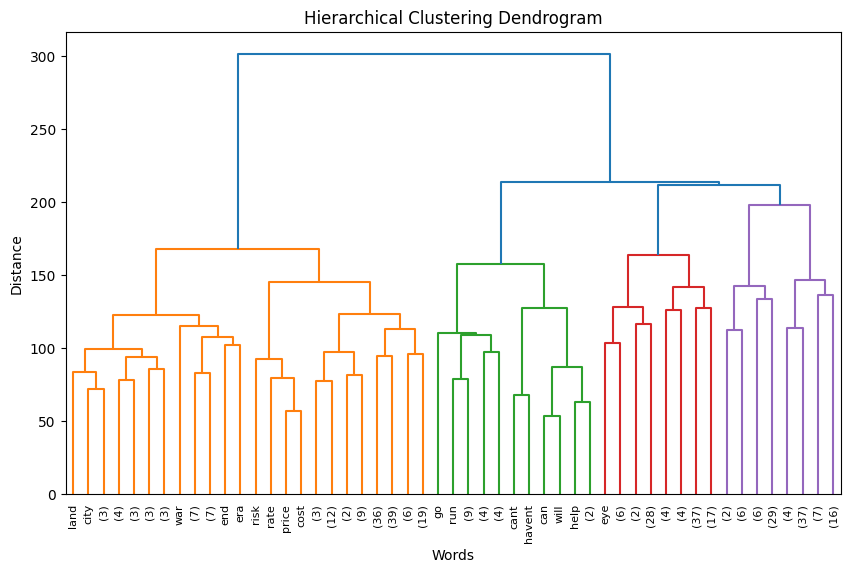

In [54]:
Z = linkage(word_vectors.values, method='ward')

plt.figure(figsize=(10,6))
dendrogram(Z, p = 5, truncate_mode = "level", orientation='top', labels = popular_words, leaf_font_size = 8)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Words')
plt.ylabel('Distance')
plt.show()

In [55]:
cluster_labels = fcluster(Z, t = 75,  criterion="distance")

clusters = {}
for word, label in zip(popular_words, cluster_labels):
    if label not in clusters:
        clusters[label] = [word]
    else:
        clusters[label].append(word)

for label, words in clusters.items():
    print(f"Cluster {label}: {', '.join(words)}")

Cluster 68: game, play, player, playing
Cluster 57: puzzle, pirate, horror, zomby, pawn, zombie, wolf, franchise, coop, nightmare, pve, limbo, gamei, fable, eargasm, glado, clue, chill, hacker, cannibal
Cluster 21: experience, community, work, environment, resource, workshop, focus, knowledge, research, project, practice, learning
Cluster 75: gameplay, gamer, gaming, rng, bonus, replay, cue
Cluster 99: way, pace
Cluster 97: hour, week, night
Cluster 12: price, cost
Cluster 47: person, friend, boss, child, woman, family, partner
Cluster 48: love, choice, voice, wish, reward, hope, enjoyment, pleasure, praise
Cluster 62: character, hero, genre, plot, figure, episode, cutscene, lore, chapter, legend, protagonist, narrator, backstory
Cluster 1: world, city, country, nation
Cluster 54: fun
Cluster 19: level, point, number, class, rating
Cluster 72: review, note, view, guide
Cluster 76: graphic, visual, video, pixel
Cluster 18: content, quality, value, product
Cluster 52: lot
Cluster 4: part

In [56]:
def words_to_list(words_string):
    return words_string.split()

clusters_df = pd.read_csv('clusters.csv', converters={'Words': words_to_list})
clusters_df

,Cluster,Words
0,68,"[game, play, player, playing]"
1,57,"[puzzle, pirate, horror, zomby, pawn, zombie, ..."
2,21,"[experience, community, work, environment, res..."
3,75,"[gameplay, gamer, gaming, rng, bonus, replay, ..."
4,99,"[way, pace]"
...,...,...
98,13,[rate]
99,74,[key]
100,44,[role]
101,2,[land]


In [57]:
clusters = {7: 'Combat',
    95: 'Combat',
    75: 'Gameplay',
    19: 'Game Mechanics',
    99: 'Game Mechanics',
    25: 'Challenges',
    76: 'Visuals',
    87: 'Visuals',
    67: 'Visuals',
    56: 'Humor',
    62: 'Narrative and Story',
    22: 'Narrative and Story',
    63: 'Bugs and Glitches',
    77: 'Updates and Patches',
    21: 'Community and Collaboration',
    12: 'Cost',
    24: 'Cost',
    18: 'Content Quality',
    8: 'Quests and Adventures',
    16: 'Production and Development',
    72: 'User Feedback',
    48: 'Enjoyment and Reward'}

In [58]:
categories = clusters_df.groupby(clusters_df['Cluster'].map(clusters)).agg({'Words': 'sum'}).reset_index()
categories

,Cluster,Words
0,Bugs and Glitches,"[bug, glitch]"
1,Challenges,"[challenge, problem, effect, reason, possibili..."
2,Combat,"[enemy, fight, battle, combat, campaign, effor..."
3,Community and Collaboration,"[experience, community, work, environment, res..."
4,Content Quality,"[content, quality, value, product]"
5,Cost,"[price, cost, worth, waste, purchase, payment,..."
6,Enjoyment and Reward,"[love, choice, voice, wish, reward, hope, enjo..."
7,Game Mechanics,"[way, pace, level, point, number, class, rating]"
8,Gameplay,"[gameplay, gamer, gaming, rng, bonus, replay, ..."
9,Humor,"[humor, classic, vibe, gem, hint, quirk, charm]"
